In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='P003':
    print('Not in /P003 folder, changing directory to P003')
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

Not in /P003 folder, changing directory to P003


In [4]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,5)
# matplotlib.rcParams['font.size']= 22 # use for presentation


if torch.cuda.is_available():
    device = torch.device('cuda')
#     device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


In [5]:
from torch.nn import MSELoss, L1Loss
# Neural network implementations: fcNet, diffNet
from src.nnets import fcNet, diffNet, get_model, train_model
from src.utils import mse, lagged_xcorr

In [6]:
with open('persistence_T18.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
lead_time = persistence['lead_time']
print('Persistence:',persistence)

Persistence: {'lead_time': 18, 'Persistence_Euclidean': 0.10196654967828511, 'Persistence_MSE': 0.20393309935657022, 'Persistence_MAE': 0.3105751548586914}


In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

    
class diffNet_scaler(nn.Module):
    '''
    Difference network. Computes y(T+lead_time) = diffNet(x, y(T+0)).
    '''
    def __init__(self,**kwargs):
        super(diffNet_scaler,self).__init__()
        self.input_dim = kwargs['input_dim']
        
        self.weights = nn.Parameter(torch.randn(1, self.input_dim))
        torch.nn.init.xavier_uniform_(self.weights, torch.nn.init.calculate_gain('tanh'))
        
        self.net = fcNet(**kwargs)
        
    def forward(self, x, Y0):
        x_new = torch.tanh( torch.clamp(self.weights,min=0.0)*x)
        return self.net(x_new) + Y0



def get_model(net_type='fcNet', opt_type = 'Adam',
              model_kwargs = {}, solver_kwargs = {}, device=torch.device("cpu")):
    '''
    Arg-s:
    - net_type : type of the network model, one of ['fcNet', 'diffNet'].
    - opt_type : type of solver/optimizer one of ['Adam', 'SGD'].
    - model_kwargs : dict of arguments for the model,
    e.g. {input_dim=5, layer_dims=[8,4], output_dim=1}
    - solver_kwargs: dict of arg-s for solver/optimizer
    '''
    models = {'fcNet': fcNet, 'diffNet':diffNet, 'diffNet_scaler':diffNet_scaler}
    model = models[net_type](**model_kwargs).to(device)
    
    optims = {'Adam': optim.Adam, 'SGD': optim.SGD}
    opt = optims[opt_type](model.parameters(), **solver_kwargs)
    return model, opt


def train_model_dl(model,train_dl,test_dl,opt, loss_func,
                epochs=100, test_intervl=25, print_times=10, scheduler=None):
    '''
    Arg-s:
    - optim : optimizer/ solver
    - test_intervl: collect loss every "test_intervl" iter-n
    - print_times : number of times to print loss to the terminal
    - epochs : total number of training epochs == training iterations for the batch
    '''
    train_epochs=[]
    train_loss=[]
    test_loss=[]
    #     test_epochs=[]
    
    # Training iterations:
    for epoch in range(epochs):
        model.train()
        epoch_loss =0
        num_total = 0
        for x,y0, y in train_dl:
            # x= x.to(device)
            # y0= y0.to(device)
            # y= y.to(device)
            pred = model(x,y0)
            loss = loss_func(pred, y)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            epoch_loss+=len(x)*loss.item()
            num_total+=len(x)
        train_epochs.append(epoch)
        train_loss.append(epoch_loss/num_total)
        
        model.eval() # for validation
        with torch.no_grad():
            # save for plotting
            nums,losses = zip(*[[len(x), loss_func(
                model(x.to(device),y0.to(device)), y.to(device)).item() ]
                                for x,y0,y in test_dl])
            nums,losses = zip(*[ 
                [len(x), loss_func(model(x,y0, y)).item() ] for x,y0,y in test_dl ]
                             )
            test_loss.append(np.sum(np.multiply(nums,losses))/np.sum(nums))
            
            # print to terminal
        if epoch%(epochs//print_times)==0:
            print('epoch {}> train_loss: {}, test_loss: {}'.format(
                epoch,train_loss[-1],test_loss[-1]))
            #print(scheduler.get_lr()) # to verify lr
        if scheduler!=None:
            # change learning rate
            scheduler.step()
    return train_epochs, train_loss, test_loss


In [8]:
# Path for Datasets:
# all preprocessed data will be saved in `data_path`
data_path = os.path.relpath('../../../dataDIR/'+'preprocessed_linearinterp_avgmodels')
print(f'> Preprocessed data is from `{data_path}`\n')
# !ls $data_path

> Preprocessed data is from `../../../dataDIR/preprocessed_linearinterp_avgmodels`



## Train

### Clock

```
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1
```

for `YXdifwind40_speedclock` 

In [89]:
# ls $data_path

Shapes
train: torch.Size([29371, 370]) torch.float32,
test: torch.Size([1546, 370]) torch.float32

Training x torch.Size([29371, 368]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 368]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.21244914829730988, test_loss: 0.20926649868488312
epoch 22> train_loss: 0.10416122525930405, test_loss: 0.11678924411535263
epoch 44> train_loss: 0.051801908761262894, test_loss: 0.06916532665491104
epoch 66> train_loss: 0.040289029479026794, test_loss: 0.06098055839538574
epoch 88> train_loss: 0.03576664626598358, test_loss: 0.057765088975429535
epoch 110> train_loss: 0.03314194455742836, test_loss: 0.05616079270839691
epoch 132> train_loss: 0.031504228711128235, test_loss: 0.05563873052597046
epoch 154> train_loss: 0.02962976135313511, test_loss: 0.05515741929411888
epoch 176> train_loss: 0.027943970635533333, test_loss: 0.05490942299365997
epoch 198> train_loss: 0.026139533147215843,

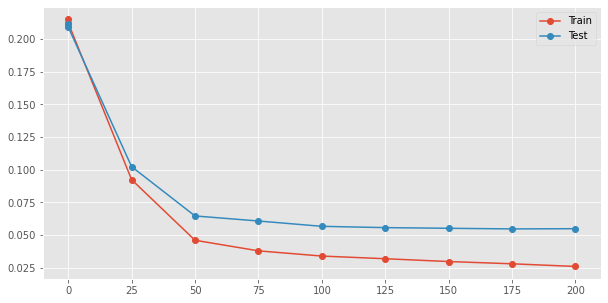

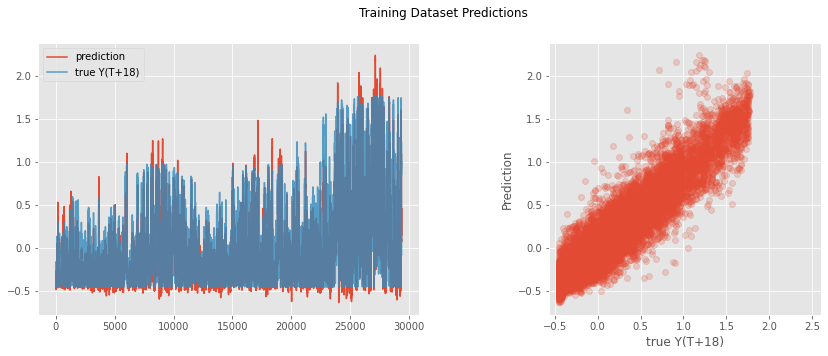

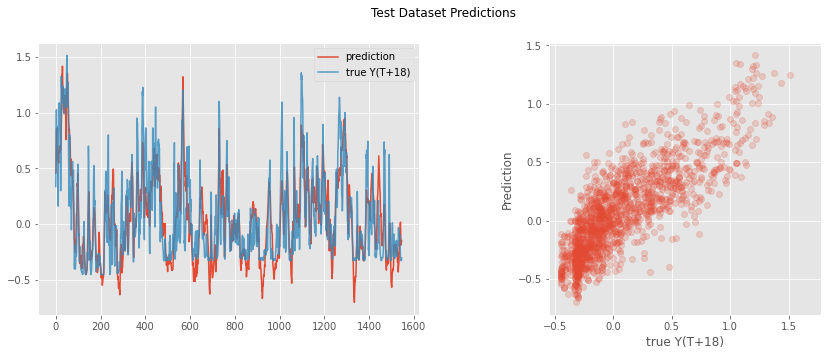

MSE loss (np): 0.054732557


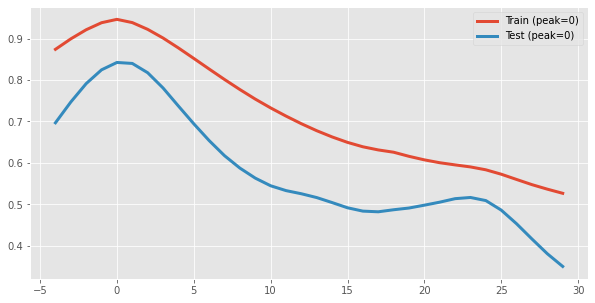

Train lag peak:0
Test lag peak:0


In [121]:
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 220    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

In [1]:
pred.ravel()[-1]

NameError: name 'pred' is not defined

In [110]:
net.cpu()
import pickle
file_name = './best_models/24Jul2020_0150_ver5.pkl'
# Save
with open(file_name, 'wb') as f:
  pickle.dump(net, f)

/mnt/mbi/home/murat/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Diff windows, current

In [66]:
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))#  data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])



epoch 0> train_loss: 0.21106979250907898, test_loss: 0.21014578640460968
epoch 100> train_loss: 0.060190409421920776, test_loss: 0.08913116902112961
epoch 200> train_loss: 0.04821259155869484, test_loss: 0.08205714821815491
epoch 300> train_loss: 0.04415755718946457, test_loss: 0.08551980555057526
epoch 400> train_loss: 0.04011187329888344, test_loss: 0.08490102738142014
epoch 500> train_loss: 0.03599635884165764, test_loss: 0.08614854514598846
epoch 600> train_loss: 0.03731836378574371, test_loss: 0.08847103267908096
epoch 700> train_loss: 0.03219868615269661, test_loss: 0.08667153865098953
epoch 800> train_loss: 0.03584980592131615, test_loss: 0.0898716002702713
epoch 900> train_loss: 0.03448764979839325, test_loss: 0.09036990255117416


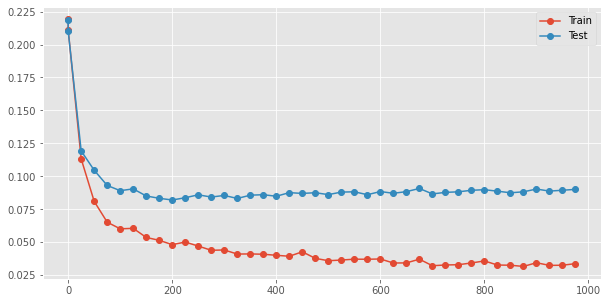

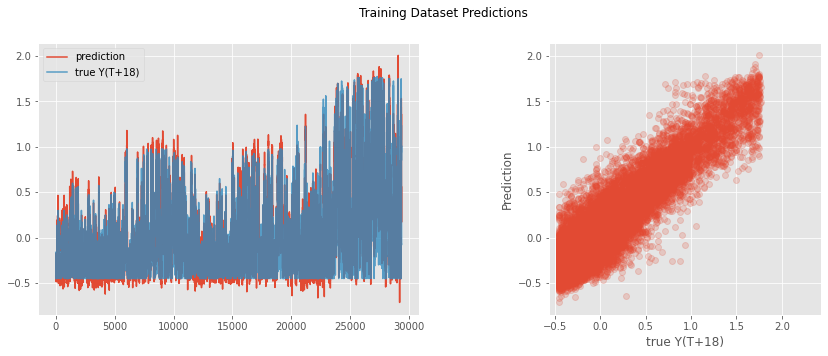

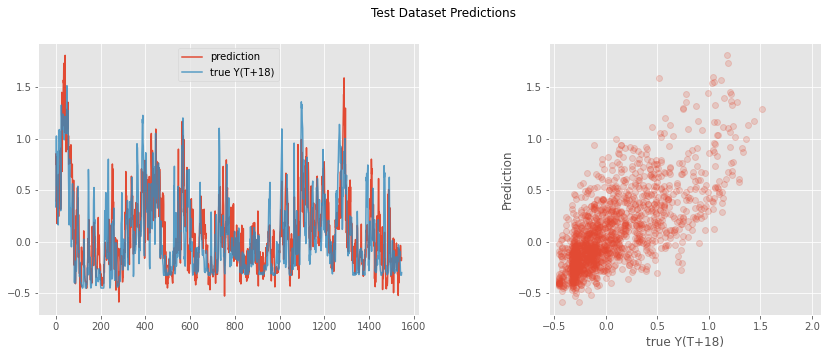

MSE loss (np): 0.088663995


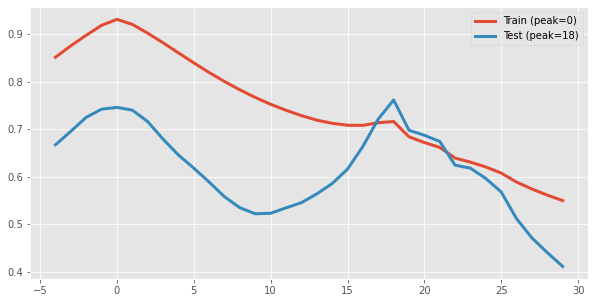

Train lag peak:0
Test lag peak:18


In [68]:
# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,128,64,64]
dropout_p = [.5] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1

# net = diffNet_scaler(input_dim=input_dim,layer_dims=layer_dims,
#                      output_dim=output_dim, dropout_p=dropout_p, acFn=nn.ReLU).to(device)
opt = torch.optim.Adam(net.parameters(),lr=0.0001)

# Training parameters
learning_rate = 0.003 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
# loss_func = L1Loss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet_scaler','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p, 'acFn':nn.ReLU},
                    solver_kwargs={'lr':learning_rate},device=device)

# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
scheduler=None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Default

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.21372239291667938, test_loss: 0.2130798101425171
epoch 25> train_loss: 0.0886412262916565, test_loss: 0.0953533798456192
epoch 50> train_loss: 0.054596636444330215, test_loss: 0.06727402657270432
epoch 75> train_loss: 0.04457326605916023, test_loss: 0.06196429952979088
epoch 100> train_loss: 0.03923218697309494, test_loss: 0.058862023055553436
epoch 125> train_loss: 0.03633210062980652, test_loss: 0.057435888797044754
epoch 150> train_loss: 0.03365619480609894, test_loss: 0.056764867156744
epoch 175> train_loss: 0.031139617785811424, test_loss: 0.055704113095998764
epoch 200> train_loss: 0.028716878965497017, test_loss: 0.05514954775571823
epoch 225> train_loss: 0.027087626978754997, te

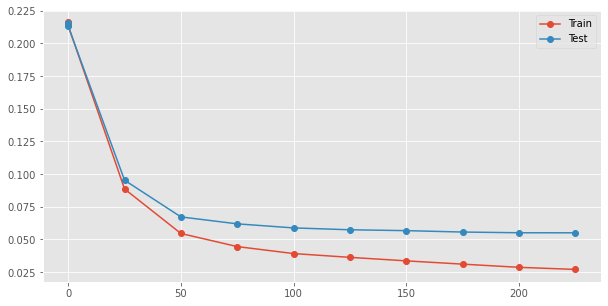

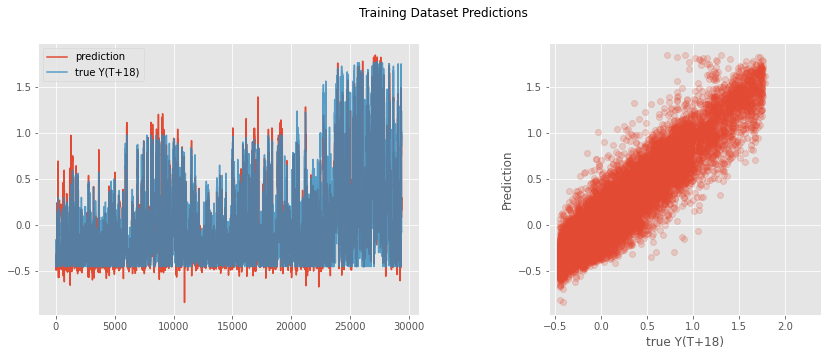

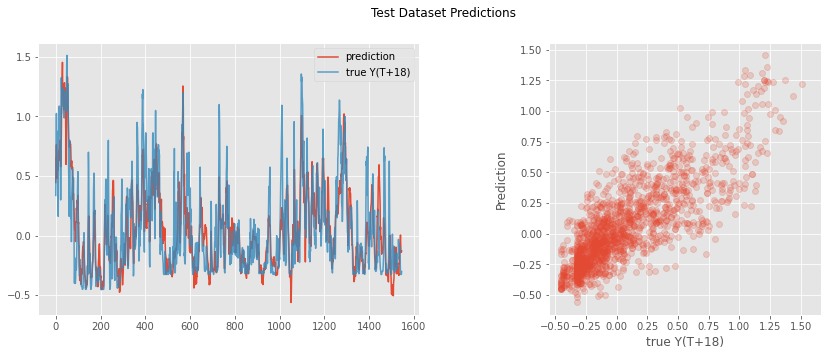

MSE loss (np): 0.054947007


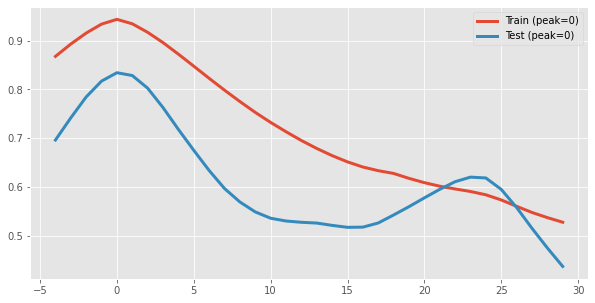

Train lag peak:0
Test lag peak:0


In [84]:
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))#  data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')

x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)
print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1

# Training parameters
learning_rate = 0.001 # default for Adam
epochs = 250    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
# loss_func = L1Loss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler

net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p, 'acFn':nn.ReLU},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler=None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)


plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

In [ ]:
plt.hist(np.abs(target_test-pred_test),bins=100,color='r',alpha=.4)
plt.hist(np.abs(t1-p1),bins=100,color='b',alpha=.4);